In [ ]:
!pip install git+https://github.com/albumentations-team/albumentations.git

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-aspw4uz_
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-aspw4uz_
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98174 sha256=41f56a5749579701549de0472530bd364706510414ff9099e79eb7664529fbdf
  Stored in directory: /tmp/pip-ephem-wheel-cache-kazcxcn5/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Let's visualize some of the images
%matplotlib inline
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm 

from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [ ]:
class Transforms:
    def __init__(self, transforms: A.Compose):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))

### **Data Exploration**

In [ ]:
train_data = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor()]
    )
)

print(train_data.data.mean(axis=(0, 1, 2))/255)


Extracting ./data/cifar-10-python.tar.gz to ./data
[0.49139968 0.48215841 0.44653091]


In [ ]:
len(train_data)

50000

In [ ]:
train_data.data.shape

(50000, 32, 32, 3)

### **Transformations**

* **Transformations used on Train Data**
  * Horizontal Flip
  * ShiftScaleRotate
  * Coarse Dropout

* References:
  * [albumentation_doocs](https://albumentations.ai/docs/examples/pytorch_classification/)
  * [video_tutorial](https://www.youtube.com/watch?v=rAdLwKJBvPM&ab_channel=AladdinPersson)
  * [albumentations_classes](https://albumentations.ai/docs/api_reference/augmentations/transforms/)

In [ ]:
train_transform = A.Compose([
            A.HorizontalFlip(p=0.3),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_REFLECT_101, always_apply=False, p=0.5),
            A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value = None),
            A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
            ToTensorV2(),
        ])

test_transform = A.Compose([
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
    ToTensorV2(),
])

In [ ]:
SEED = 42

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [ ]:
train_transform = Transforms(train_transform)
test_transform = Transforms(test_transform)

### **Download And Load Train, Test Data**

In [ ]:
train = datasets.CIFAR10(root='./data', train=True,
                        download=True, transform=train_transform)
test = datasets.CIFAR10(root='./data', download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train, 
                                          batch_size=128, 
                                          shuffle=True,
                                          num_workers=2, 
                                          pin_memory=True)
test_loader = torch.utils.data.DataLoader(test, 
                                          batch_size=128,  
                                          shuffle=False,
                                          num_workers=2, 
                                          pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
use_cuda = torch.cuda.is_available()
device = 'cuda:0' if use_cuda else 'cpu'

### **Model Design**

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

### **Model Summary**

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

### **Train Function**

In [ ]:
def train(model, device, train_loader, optimizer, scheduler, criterion, train_acc, train_loss):   
    model.train()
    pbar = tqdm(train_loader)

    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data["image"].to(device), target.to(device)

        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = criterion(y_pred, target)

        train_loss.append(loss.data.cpu().numpy().item())

        # Backpropagation
        loss.backward()

        optimizer.step()
        scheduler.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(
            desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100 * correct / processed:0.2f}')
        train_acc.append(100 * correct / processed)

### **Test Function**

In [ ]:
def test(model, device, test_loader, test_acc, test_losses):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data["image"].to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

### **Train And Test the Model**

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.7)
scheduler = OneCycleLR(optimizer, max_lr=0.015, epochs=20, steps_per_epoch=len(train_loader))

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(1, 21):
    print(f'Epoch {epoch}:')
    train(model, device, train_loader, optimizer,scheduler,criterion, train_accuracy, train_losses)

    test(model, device, test_loader,test_accuracy, test_losses)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1:


Loss=1.3999443054199219 Batch_id=390 Accuracy=37.66: 100%|██████████| 391/391 [01:00<00:00,  6.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Accuracy: 26889/50000 (53.78%)

Epoch 2:


Loss=1.1783843040466309 Batch_id=390 Accuracy=52.59: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 30147/50000 (60.29%)

Epoch 3:


Loss=1.2370483875274658 Batch_id=390 Accuracy=59.18: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 33166/50000 (66.33%)

Epoch 4:


Loss=0.9669938087463379 Batch_id=390 Accuracy=65.14: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 34474/50000 (68.95%)

Epoch 5:


Loss=0.797508716583252 Batch_id=390 Accuracy=69.16: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 39370/50000 (78.74%)

Epoch 6:


Loss=0.7974386215209961 Batch_id=390 Accuracy=72.30: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 39849/50000 (79.70%)

Epoch 7:


Loss=0.534843921661377 Batch_id=390 Accuracy=74.84: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 42409/50000 (84.82%)

Epoch 8:


Loss=0.6523258686065674 Batch_id=390 Accuracy=76.58: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 41625/50000 (83.25%)

Epoch 9:


Loss=0.459796667098999 Batch_id=390 Accuracy=78.44: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 44064/50000 (88.13%)

Epoch 10:


Loss=0.8597472310066223 Batch_id=390 Accuracy=79.59: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 44717/50000 (89.43%)

Epoch 11:


Loss=0.590587317943573 Batch_id=390 Accuracy=80.60: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 45680/50000 (91.36%)

Epoch 12:


Loss=0.514376699924469 Batch_id=390 Accuracy=82.04: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 45724/50000 (91.45%)

Epoch 13:


Loss=0.5326727032661438 Batch_id=390 Accuracy=82.92: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 46146/50000 (92.29%)

Epoch 14:


Loss=0.43420442938804626 Batch_id=390 Accuracy=84.29: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 47000/50000 (94.00%)

Epoch 15:


Loss=0.35513705015182495 Batch_id=390 Accuracy=85.34: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 47206/50000 (94.41%)

Epoch 16:


Loss=0.39158448576927185 Batch_id=390 Accuracy=86.49: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 47894/50000 (95.79%)

Epoch 17:


Loss=0.18946602940559387 Batch_id=390 Accuracy=87.83: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 48532/50000 (97.06%)

Epoch 18:


Loss=0.40104013681411743 Batch_id=390 Accuracy=88.91: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 48995/50000 (97.99%)

Epoch 19:


Loss=0.3465620279312134 Batch_id=390 Accuracy=89.69: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 49160/50000 (98.32%)

Epoch 20:


Loss=0.31162649393081665 Batch_id=390 Accuracy=90.03: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]



Test set: Average loss: 0.0005, Accuracy: 49193/50000 (98.39%)



### **Train, Validation Loss and Accuracy Plots**

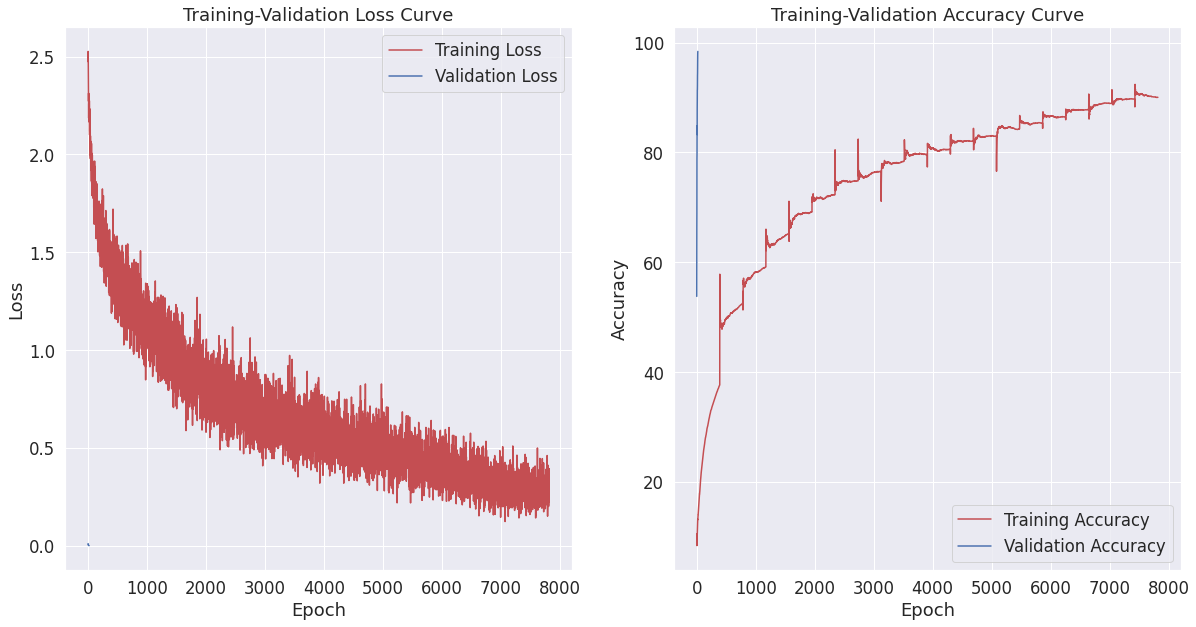

In [ ]:
import seaborn as sns

sns.set(style='whitegrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,10)

# Plot the learning curve.
fig, (plt1,plt2) = plt.subplots(1,2)
plt1.plot(train_losses, 'r', label="Training Loss")
plt1.plot(test_losses, 'b', label="Validation Loss")
plt2.plot(train_accuracy, 'r', label="Training Accuracy")
plt2.plot(test_accuracy, 'b', label="Validation Accuracy")

plt2.set_title("Training-Validation Accuracy Curve")
plt2.set_xlabel("Epoch")
plt2.set_ylabel("Accuracy")
plt2.legend()
plt1.set_title("Training-Validation Loss Curve")
plt1.set_xlabel("Epoch")
plt1.set_ylabel("Loss")
plt1.legend()

plt.show()

### **Classwise Predictions**

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images["image"].to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 97 %
Accuracy of   cat : 93 %
Accuracy of  deer : 96 %
Accuracy of   dog : 97 %
Accuracy of  frog : 98 %
Accuracy of horse : 98 %
Accuracy of  ship : 100 %
Accuracy of truck : 98 %


In [ ]:
wrong_images = []
wrong_label = []
correct_label = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data["image"].to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True).squeeze()

        wrong_pred = (pred.eq(target.view_as(pred)) == False)
        wrong_images.append(data[wrong_pred])
        wrong_label.append(pred[wrong_pred])
        correct_label.append(target.view_as(pred)[wrong_pred])

        wrong_predictions = list(zip(torch.cat(wrong_images), torch.cat(wrong_label), torch.cat(correct_label)))
    print(f'Total wrong predictions are {len(wrong_predictions)}')

Total wrong predictions are 807


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


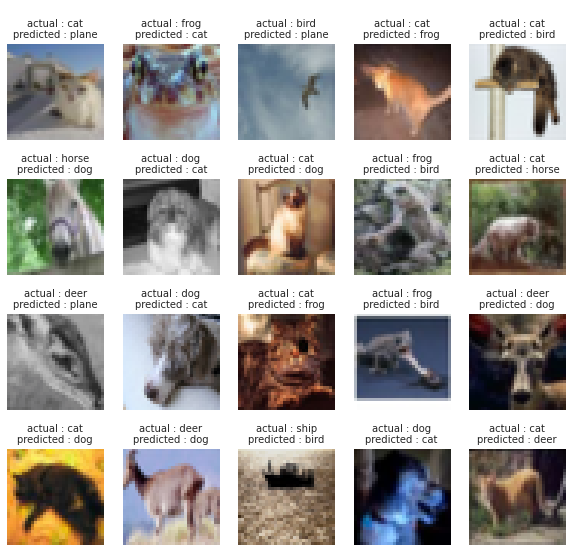

In [ ]:
fig = plt.figure(figsize=(10, 12))
fig.tight_layout()

mean = (0.49139968, 0.48215841, 0.44653091)
std = (0.24703223, 0.24348513, 0.26158784)

for i, (img, pred, correct) in enumerate(wrong_predictions[:20]):
    img, pred, target = img.cpu().numpy().astype(dtype=np.float32), pred.cpu(), correct.cpu()
    for j in range(img.shape[0]):
        img[j] = (img[j] * std[j]) + mean[j]

    img = np.transpose(img, (1, 2, 0))  # / 2 + 0.5
    ax = fig.add_subplot(5, 5, i + 1)
    ax.axis('off')
    ax.set_title(f'\nactual : {classes[target.item()]}\npredicted : {classes[pred.item()]}',
                  fontsize=10)
    ax.imshow(img)

plt.show()

In [ ]:
class GradCAM:
    """Calculate GradCAM salinecy map.
    Args:
        input: input image with shape of (1, 3, H, W)
        class_idx (int): class index for calculating GradCAM.
                If not specified, the class index that makes the highest model prediction score will be used.
    Return:
        mask: saliency map of the same spatial dimension with input
        logit: model output
    A simple example:
        # initialize a model, model_dict and gradcam
        resnet = torchvision.models.resnet101(pretrained=True)
        resnet.eval()
        gradcam = GradCAM.from_config(model_type='resnet', arch=resnet, layer_name='layer4')
        # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        img = load_img()
        normed_img = normalizer(img)
        # get a GradCAM saliency map on the class index 10.
        mask, logit = gradcam(normed_img, class_idx=10)
        # make heatmap from mask and synthesize saliency map using heatmap and img
        heatmap, cam_result = visualize_cam(mask, img)
    """

    def __init__(self, model, layer_name):
        self.model = model
        # self.layer_name = layer_name
        self.target_layer = layer_name

        self.gradients = dict()
        self.activations = dict()

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]

        def forward_hook(module, input, output):
            self.activations['value'] = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    @classmethod
    def from_config(cls, arch: torch.nn.Module, model_type: str, layer_name: str):
        target_layer = layer_finders[model_type](arch, layer_name)
        return cls(arch, target_layer)

    def saliency_map_size(self, *input_size):
        device = next(self.model_arch.parameters()).device
        self.model(torch.zeros(1, 3, *input_size, device=device))
        return self.activations['value'].shape[2:]

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()

        logit = self.model(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        # alpha = F.relu(gradients.view(b, k, -1)).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map, logit

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)

In [ ]:
import cv2
def visualize_cam(mask, img, alpha=1.0):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]
    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    heatmap = (255 * mask.squeeze()).type(torch.uint8).cpu().numpy()
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b]) * alpha

    result = heatmap+img.cpu()
    result = result.div(result.max()).squeeze()

    return heatmap, result

In [ ]:
import PIL
import numpy as np
import torchvision
from torchvision.utils import make_grid

In [ ]:
def imshow(img,c = "" ):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)

In [ ]:
count = 0
g_image_list = []
g_image_label = []
for images, label in zip(wrong_images,correct_label):
  if [images.size()] == [torch.Size([1, 3, 32, 32])]:
    g_image_list.append(images)
    g_image_label.append(label)
    count += 1
  if count >= 10:
    break

In [ ]:
print(len(g_image_list))
print(len(g_image_label))

10
10


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255

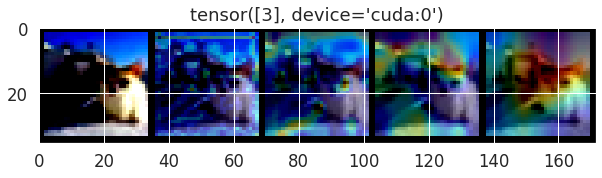

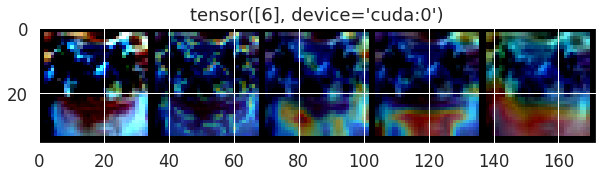

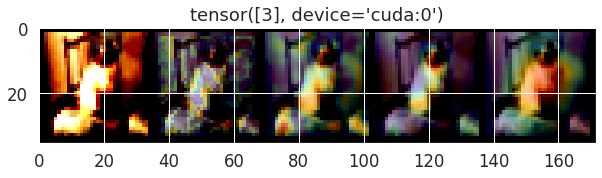

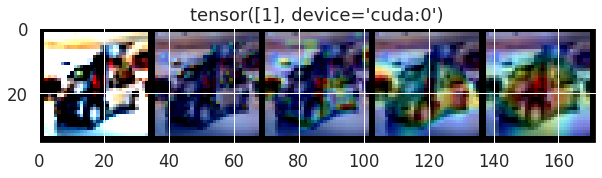

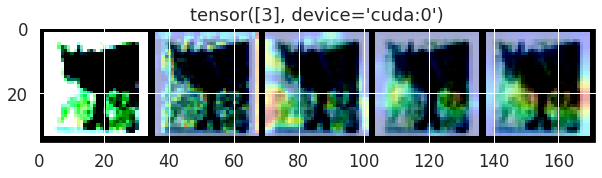

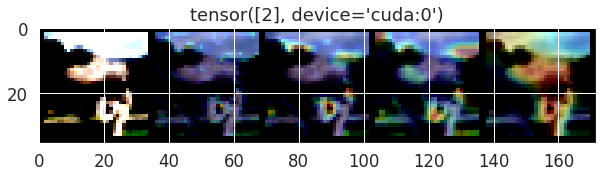

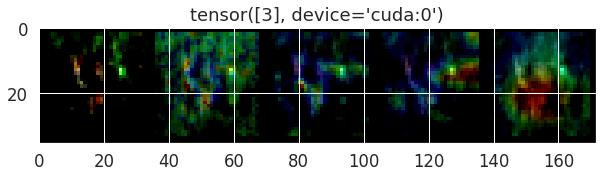

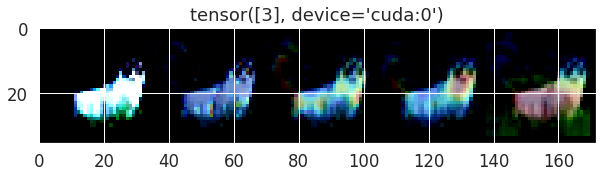

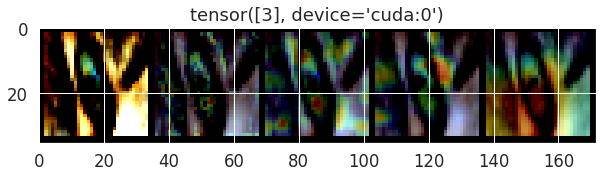

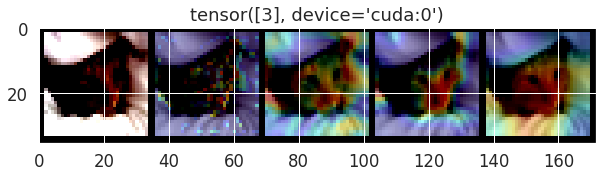

In [ ]:
for image, label in zip(g_image_list,g_image_label):
    torch_img = torchvision.utils.make_grid(torch.unsqueeze(image, 0))
    plot=[]
    g1 = GradCAM(model, model.layer1)
    g2 = GradCAM(model, model.layer2)
    g3 = GradCAM(model, model.layer3)
    g4 = GradCAM(model, model.layer4)
    mask1, _ = g1(torch_img)
    mask2, _ = g2(torch_img)
    mask3, _ = g3(torch_img)
    mask4, _ = g4(torch_img)
    heatmap1, result1 = visualize_cam(mask1, torch_img)
    heatmap2, result2 = visualize_cam(mask2, torch_img)
    heatmap3, result3 = visualize_cam(mask3, torch_img)
    heatmap4, result4 = visualize_cam(mask4, torch_img)

    plot.extend([torch_img[0].cpu(), result1, result2, result3, result4])

    grid_image = make_grid(plot, nrow=5)
    imshow(grid_image, label)